# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
!pip install wordcloud
from wordcloud import WordCloud

# 2. Load Data

In [2]:
try:
    df_apps = pd.read_csv("/content/googleplaystore.csv")
    df_reviews = pd.read_csv("/content/googleplaystore_user_reviews.csv")
    print("Files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please make sure 'googleplaystore.csv' and 'googleplaystore_user_reviews.csv' are uploaded to your Colab environment.")
    # We'll stop the script here if files aren't found
    raise e

Files loaded successfully.


# 3. Analyze Missing Data (Before Cleaning)

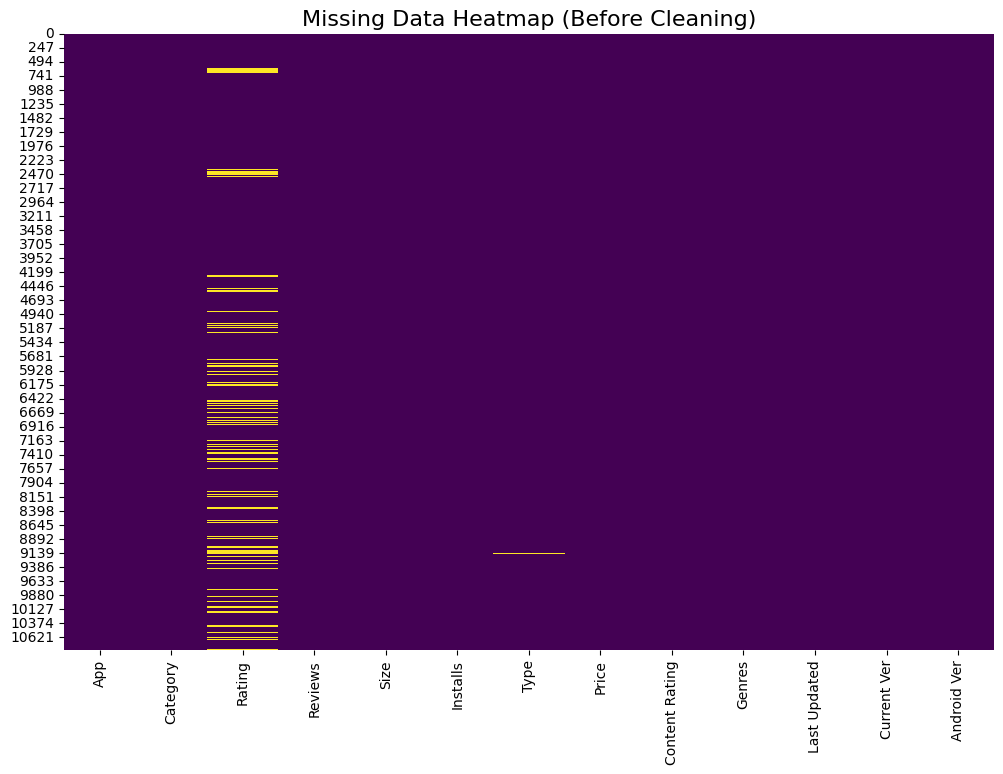

In [3]:
# Create a heatmap to show where data is missing
plt.figure(figsize=(12, 8))
sns.heatmap(df_apps.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap (Before Cleaning)', fontsize=16)
plt.show()

In [4]:
# See which categories have the most missing ratings
missing_ratings_by_category = df_apps[df_apps['Rating'].isnull()]['Category'].value_counts()
print("Categories with the most missing ratings (top 5):")
print(missing_ratings_by_category.head())

Categories with the most missing ratings (top 5):
Category
FAMILY             225
BUSINESS           157
MEDICAL            113
TOOLS              109
PERSONALIZATION     78
Name: count, dtype: int64


# 4. Clean Apps Data

## 4.1 Cleaning Reviews

In [5]:
df_apps['Reviews'] = pd.to_numeric(df_apps['Reviews'], errors='coerce')
df_apps = df_apps.dropna(subset=['Reviews'])
df_apps['Reviews'] = df_apps['Reviews'].astype(int)

## 4.2. Clean 'Rating'

In [6]:
# Convert to numeric, errors='coerce' will turn invalid ratings (like '19') into NaN
df_apps['Rating'] = pd.to_numeric(df_apps['Rating'], errors='coerce')
# Drop rows with invalid ratings > 5
df_apps = df_apps[df_apps['Rating'] <= 5]
# Fill missing ratings with the median (more robust to outliers than mean)
median_rating = df_apps['Rating'].median()
df_apps['Rating'] = df_apps['Rating'].fillna(median_rating)

## 4.3. Clean 'Installs'

In [7]:
df_apps['Installs'] = df_apps['Installs'].str.replace('+', '', regex=False)
df_apps['Installs'] = df_apps['Installs'].str.replace(',', '', regex=False)
df_apps['Installs'] = pd.to_numeric(df_apps['Installs'])

## 4.4. Clean 'Size'

In [8]:
# Helper function for cleaning 'Size'
def clean_size(size):
    if isinstance(size, str):
        if 'M' in size:
            return float(size.replace('M', '')) * 1_000_000  # Convert to bytes
        elif 'k' in size:
            return float(size.replace('k', '')) * 1_000      # Convert to bytes
        elif 'Varies with device' in size:
            return np.nan
        else:
            try:
                return float(size)
            except:
                return np.nan
    return np.nan # Handle non-string inputs if any

df_apps['Size'] = df_apps['Size'].apply(clean_size)
# Fill missing sizes with the median
median_size = df_apps['Size'].median()
df_apps['Size'] = df_apps['Size'].fillna(median_size)
# Convert size to Megabytes for easier interpretation in plots
df_apps['Size_MB'] = df_apps['Size'] / 1_000_000

## 4.5. Clean 'Price'

In [9]:
df_apps['Price'] = df_apps['Price'].str.replace('$', '', regex=False)
df_apps['Price'] = pd.to_numeric(df_apps['Price'])

## 4.6. Clean 'Type' and 'Content Rating'

In [10]:
df_apps['Type'] = df_apps['Type'].fillna('Free')
df_apps['Content Rating'] = df_apps['Content Rating'].fillna('Everyone')

## 4.7. Drop duplicate apps

In [11]:
df_apps = df_apps.sort_values('Reviews', ascending=False)
df_apps = df_apps.drop_duplicates(subset=['App'], keep='first')

# Reset index after dropping rows
df_apps = df_apps.reset_index(drop=True)

print(f"Cleaning complete. Shape of cleaned data: {df_apps.shape}")

Cleaning complete. Shape of cleaned data: (8196, 14)


# 5. Clean and Merge Reviews Data

In [12]:
# Clean the reviews dataset (simple dropna)
df_reviews_cleaned = df_reviews.dropna()

## 5.1. Merge for Sentiment Polarity

In [13]:
# First, get average sentiment for each app
df_sentiment = df_reviews_cleaned.groupby('App')['Sentiment_Polarity'].mean().reset_index()
# Merge with the main app dataframe
df_merged = pd.merge(df_apps, df_sentiment, on='App')

## 5.2. Merge Review Text for NLP

In [14]:
# Get the full concatenated text for each app
df_reviews_text = df_reviews_cleaned.groupby('App')['Translated_Review'].apply(lambda x: ' '.join(x)).reset_index()
# Merge this text data with our main df_apps
df_merged_with_text = pd.merge(df_apps, df_reviews_text, on='App')

# 6. Run Analysis & Generate Plots

## 6.1. Objective 1: Analyze App Distribution and Quality by Category

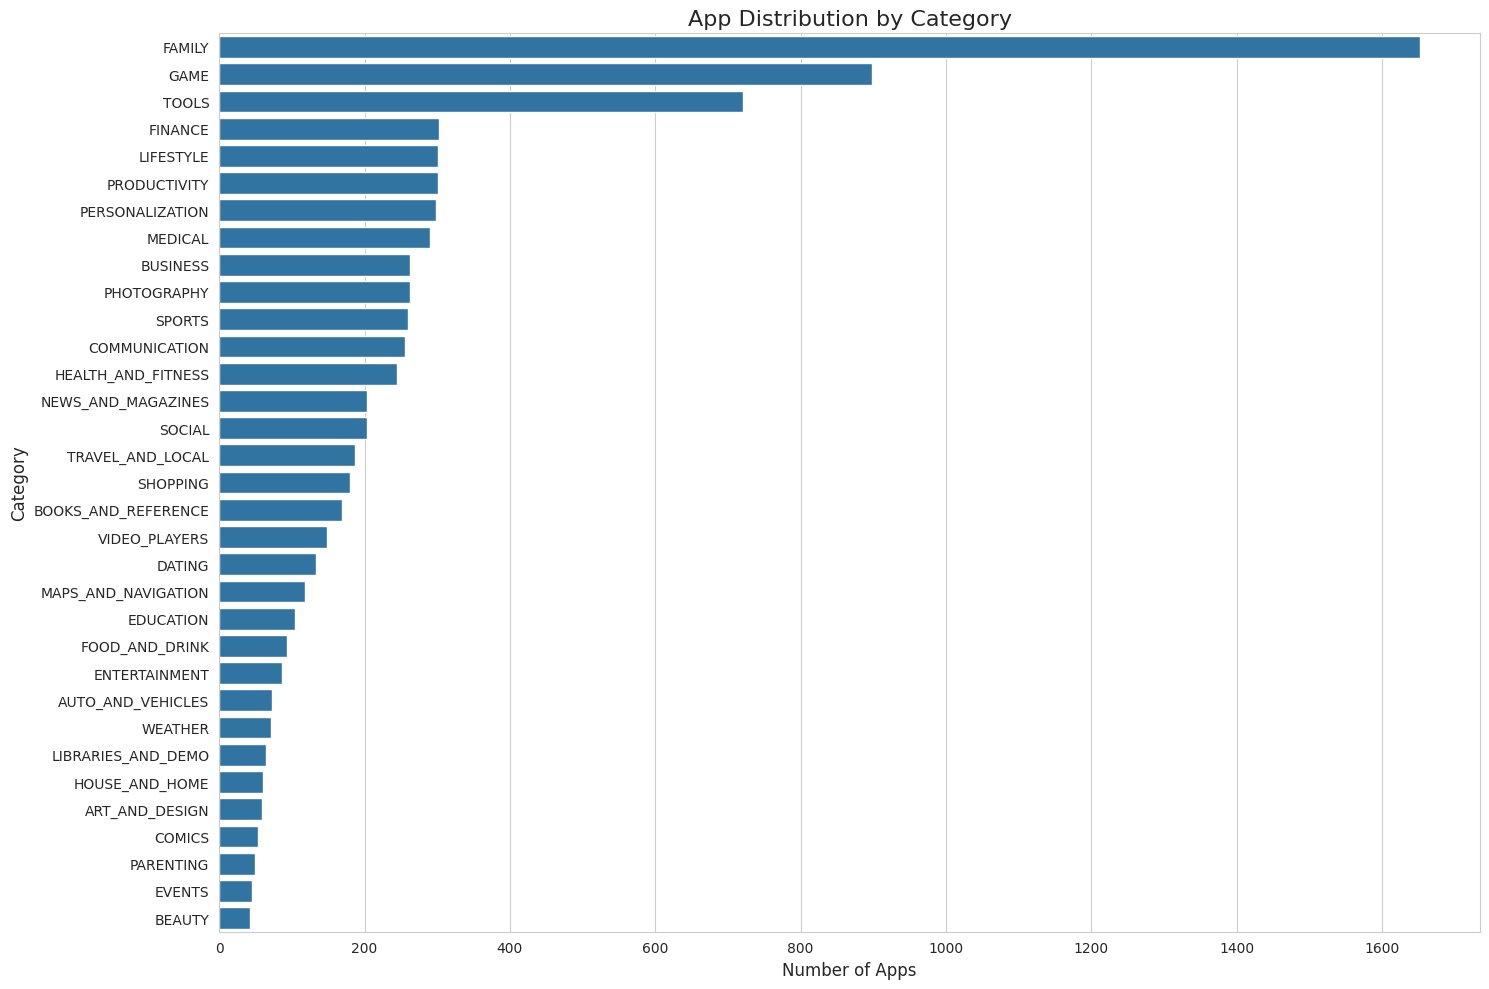

In [15]:
# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

plt.figure(figsize=(15, 10))
sns.countplot(y='Category', data=df_apps, order=df_apps['Category'].value_counts().index)
plt.title('App Distribution by Category', fontsize=16)
plt.xlabel('Number of Apps', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.show()

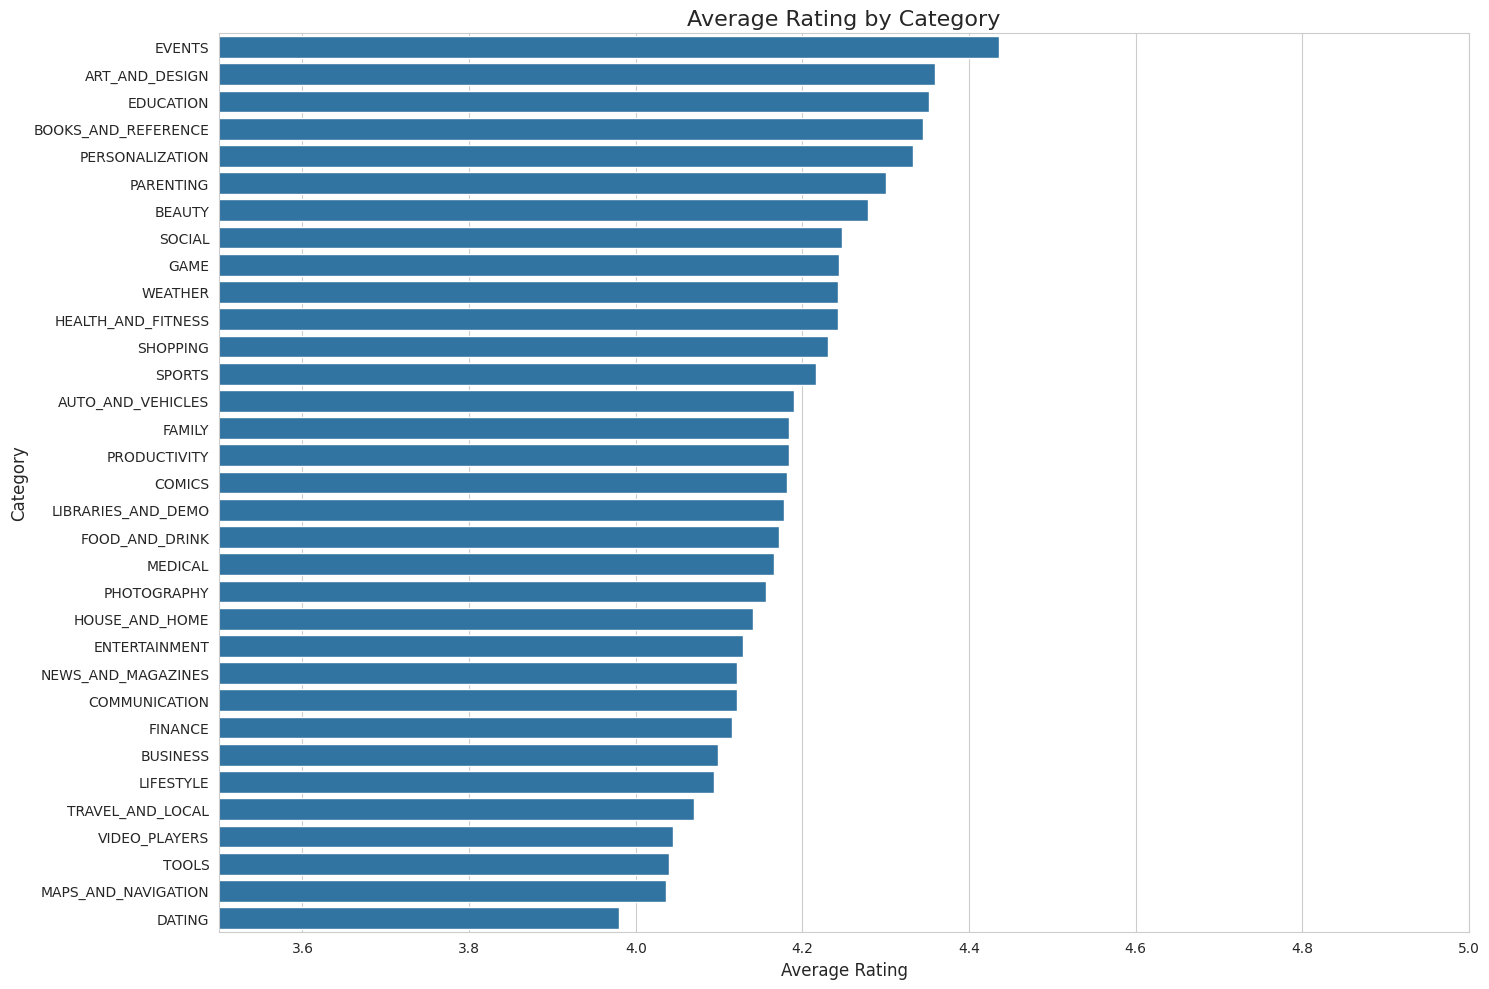

In [16]:
plt.figure(figsize=(15, 10))
category_ratings = df_apps.groupby('Category')['Rating'].mean().sort_values(ascending=False)
sns.barplot(y=category_ratings.index, x=category_ratings.values, orient='h')
plt.title('Average Rating by Category', fontsize=16)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.xlim(3.5, 5.0) # Set x-axis limit to better see differences
plt.tight_layout()
plt.show()

## 6.2. Objective 2: Pair Plot with Log Transform


--- Objective 2 (Advanced): Pair Plot with Log Transform ---


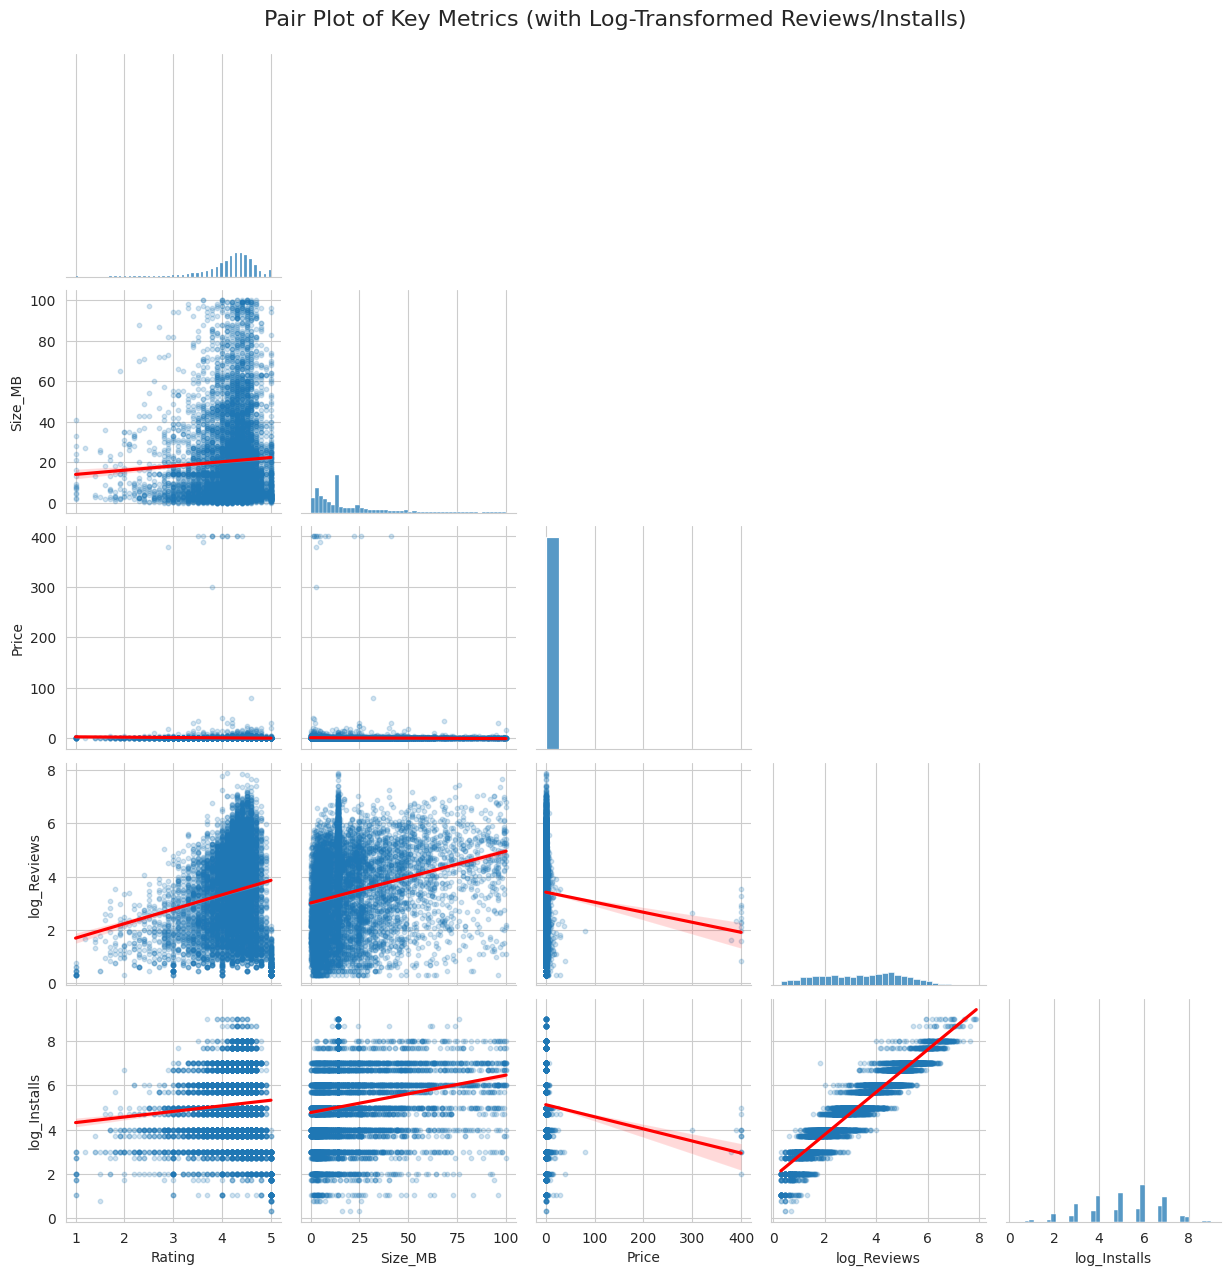

In [17]:
# (This replaces the simple correlation heatmap)
print("\n--- Objective 2 (Advanced): Pair Plot with Log Transform ---")
# Create a copy for this plot
df_pairplot = df_apps.copy()

# Apply log-transform to skewed columns (add 1 to avoid log(0))
df_pairplot['log_Reviews'] = np.log10(df_pairplot['Reviews'] + 1)
df_pairplot['log_Installs'] = np.log10(df_pairplot['Installs'] + 1)

# Columns to plot
plot_vars = ['Rating', 'Size_MB', 'Price', 'log_Reviews', 'log_Installs']

# Create the pairplot
g = sns.pairplot(df_pairplot, vars=plot_vars, kind='reg', corner=True,
                 plot_kws={'scatter_kws': {'alpha': 0.2, 's': 10}, 'line_kws': {'color': 'red'}})
g.fig.suptitle('Pair Plot of Key Metrics (with Log-Transformed Reviews/Installs)', y=1.02, fontsize=16)
plt.show()

## 6.3. Objective 3: Compare Free vs. Paid App Performance

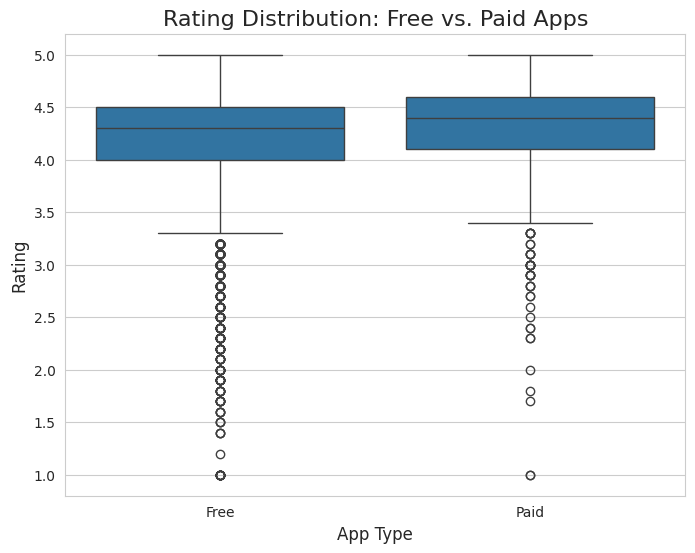

In [18]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Rating', data=df_apps)
plt.title('Rating Distribution: Free vs. Paid Apps', fontsize=16)
plt.xlabel('App Type', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.show()

In [19]:
# Get the rating data for each group
free_ratings = df_apps[df_apps['Type'] == 'Free']['Rating']
paid_ratings = df_apps[df_apps['Type'] == 'Paid']['Rating'].dropna() # Drop NaNs for paid apps if any

# Perform Mann-Whitney U test (a non-parametric test)
u_stat, p_value = stats.mannwhitneyu(free_ratings, paid_ratings, alternative='two-sided')

print(f"Mann-Whitney U Test for Free vs. Paid App Ratings:")
print(f"U-statistic = {u_stat:.2f}")
print(f"p-value = {p_value:.4f}")

if p_value < 0.05:
    print("Result: The difference in ratings between Free and Paid apps is statistically significant.")
else:
    print("Result: The difference in ratings is NOT statistically significant.")

Mann-Whitney U Test for Free vs. Paid App Ratings:
U-statistic = 1923794.00
p-value = 0.0000
Result: The difference in ratings between Free and Paid apps is statistically significant.


## 6.4 Objective 4: Correlate User Sentiment with Overall App Ratings

<Figure size 1000x600 with 0 Axes>

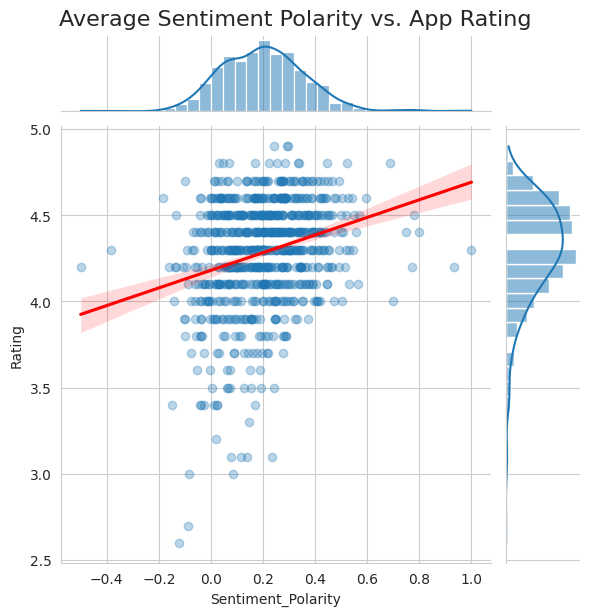

In [20]:
# Use the 'df_merged' dataframe we created for this
plt.figure(figsize=(10, 6))
# Use a jointplot for a more detailed view
sns.jointplot(x='Sentiment_Polarity', y='Rating', data=df_merged, kind='reg',
              joint_kws={'scatter_kws': {'alpha': 0.3}},
              line_kws={'color': 'red'})
plt.suptitle('Average Sentiment Polarity vs. App Rating', y=1.02, fontsize=16)
plt.show()

## 6.5. Objective 5: Assess the Impact of Content Rating

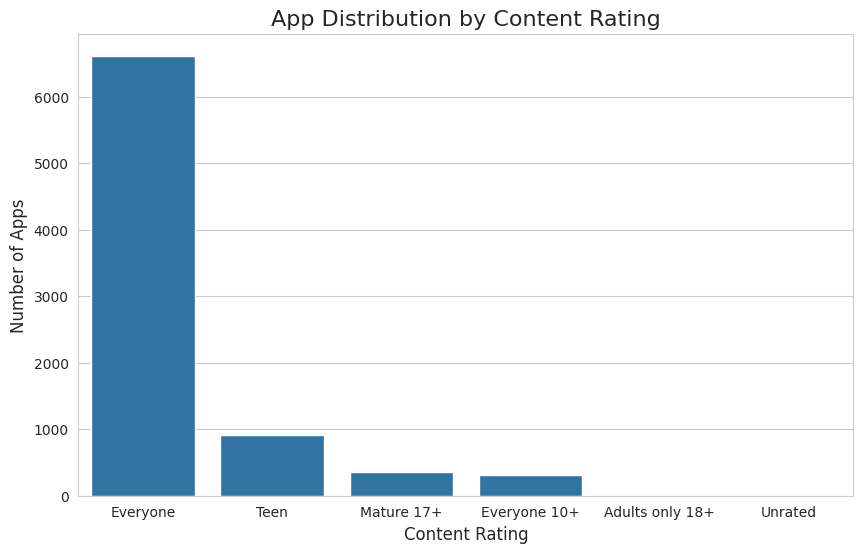

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Content Rating', data=df_apps, order=df_apps['Content Rating'].value_counts().index)
plt.title('App Distribution by Content Rating', fontsize=16)
plt.xlabel('Content Rating', fontsize=12)
plt.ylabel('Number of Apps', fontsize=12)
plt.show()

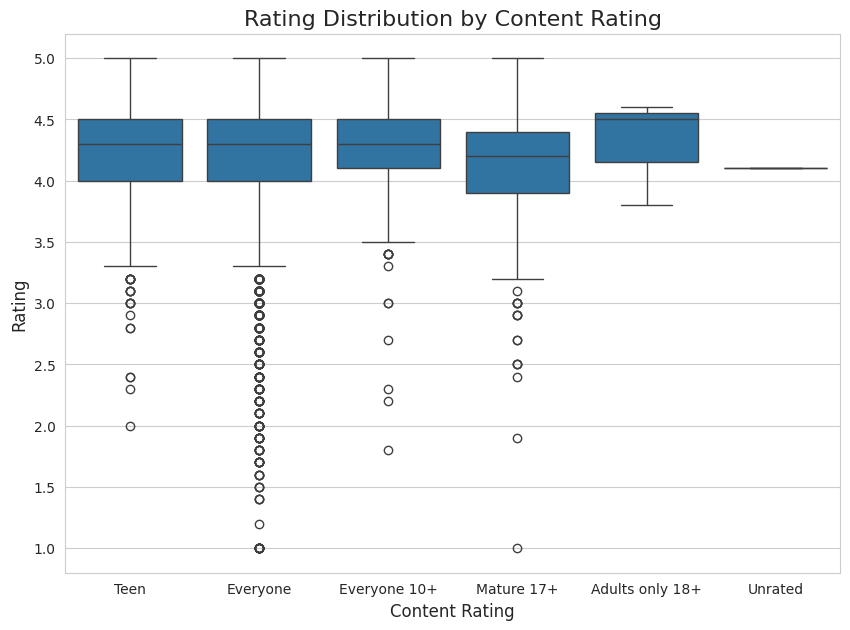

In [22]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='Content Rating', y='Rating', data=df_apps)
plt.title('Rating Distribution by Content Rating', fontsize=16)
plt.xlabel('Content Rating', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.show()

## 6.6 Objective 6: Feature Engineering & Date Analysis

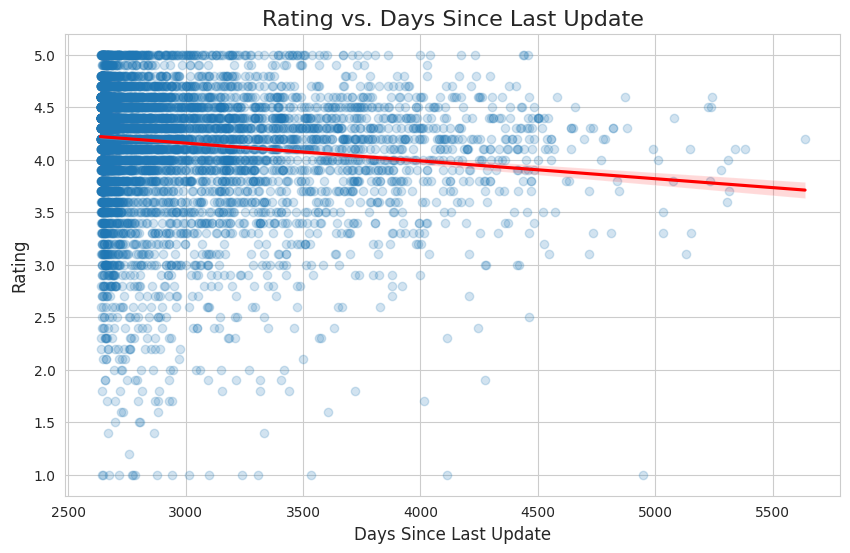

In [23]:
# Convert 'Last Updated' to datetime
df_apps['Last_Updated_DT'] = pd.to_datetime(df_apps['Last Updated'])

# Calculate 'Days_Since_Update' (as of today)
# Using .now() is fine in Colab, as it's not a live server
df_apps['Days_Since_Update'] = (pd.to_datetime('today') - df_apps['Last_Updated_DT']).dt.days

# Plot correlation
plt.figure(figsize=(10, 6))
sns.regplot(x='Days_Since_Update', y='Rating', data=df_apps, scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
plt.title('Rating vs. Days Since Last Update', fontsize=16)
plt.xlabel('Days Since Last Update', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.show()

In [24]:
# Calculate the correlation
correlation = df_apps[['Rating', 'Days_Since_Update']].corr().iloc[0,1]
print(f"Correlation between Rating and Days Since Update: {correlation:.3f}")
print("A negative correlation means apps updated more recently tend to have higher ratings.")

Correlation between Rating and Days Since Update: -0.130
A negative correlation means apps updated more recently tend to have higher ratings.


## 6.7 Objective 7: NLP Word Cloud Analysis

Generating Word Cloud for: Facebook


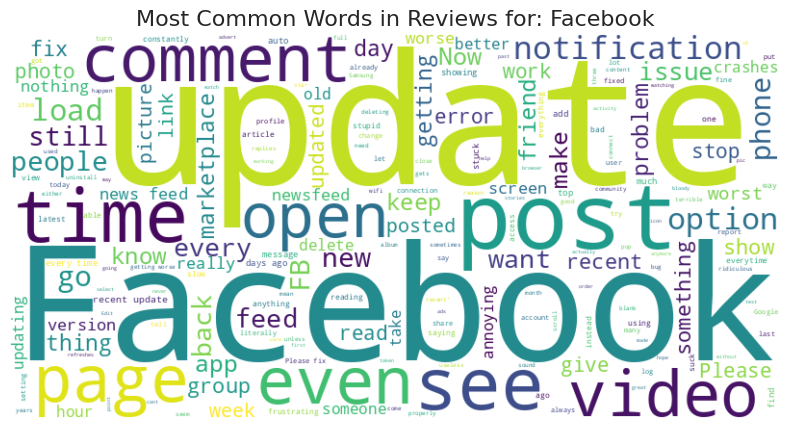

Generating Word Cloud for: Clash of Clans


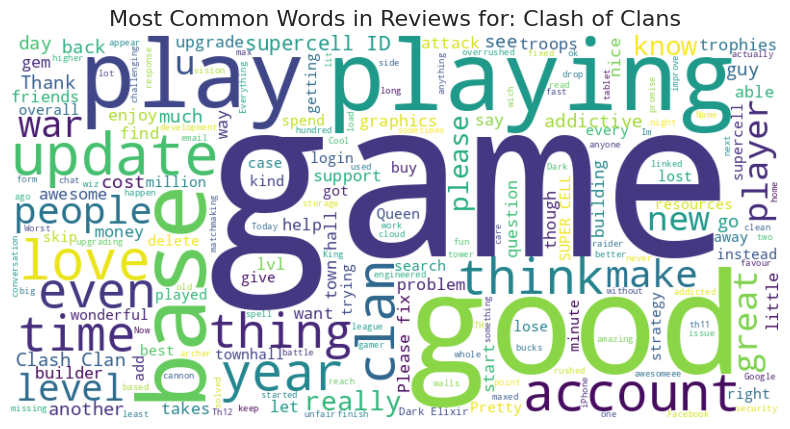

Generating Word Cloud for: Clash Royale


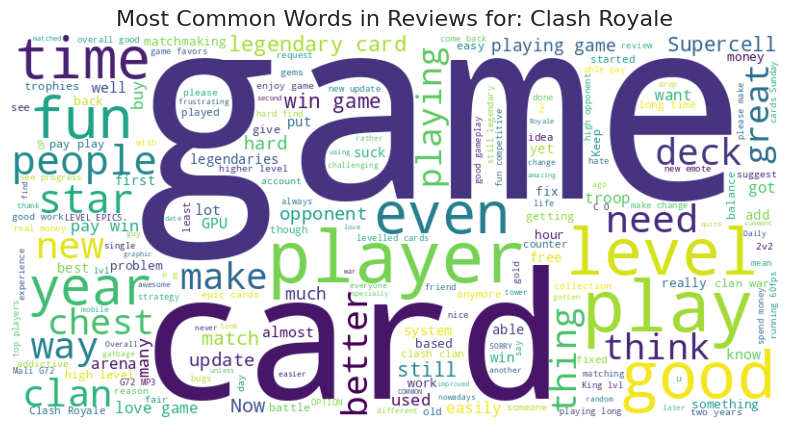

In [25]:
# Use the 'df_merged_with_text' dataframe
# Get top 3 apps by number of Reviews
top_apps = df_merged_with_text.nlargest(3, 'Reviews')['App'].tolist()

for app_name in top_apps:
    print(f"Generating Word Cloud for: {app_name}")
    # Get all reviews for that app
    text = df_merged_with_text[df_merged_with_text['App'] == app_name]['Translated_Review'].iloc[0]

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most Common Words in Reviews for: {app_name}', fontsize=16)
    plt.show()